In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
from ray import tune

In [3]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MAE, MSE, RMSE
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.losses.numpy import rmse, mape
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

C:\Users\GobatoH\Anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Kan opgegeven procedure niet vinden'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
from neuralforecast.models import NHITS

In [5]:
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [6]:
df = pd.read_excel('DJIA Realized Volatility (NBEATSx).xlsx',index_col='Date',parse_dates=True)

In [15]:
Y_train_df = df[:1005]
Y_train_df.reset_index(inplace=True)
Y_train_df.rename(columns={'Date':'ds'}, inplace=True)
Y_train_df.rename(columns={'Realised':'y'}, inplace=True)

In [16]:
Y_test_df = df[1005:1005+15]
Y_test_df.reset_index(inplace=True)
Y_test_df.rename(columns={'Date':'ds'}, inplace=True)
Y_test_df.rename(columns={'Realised':'y'}, inplace=True)

In [17]:
dataset, *_ = TimeSeriesDataset.from_df(df = Y_train_df)

In [18]:
Y_train_df

,ds,unique_id,y,US Financial Turbulence,Covid,VIX
0,2017-11-02,Airline1,0.005718,806.442547,0,9.93
1,2017-11-03,Airline1,0.002881,702.337034,0,9.14
2,2017-11-06,Airline1,0.001528,529.197112,0,9.40
3,2017-11-07,Airline1,0.003651,512.157114,0,9.89
4,2017-11-08,Airline1,0.001921,493.752126,0,9.78
...,...,...,...,...,...,...
1000,2021-10-25,Airline1,0.002847,404.686444,0,15.24
1001,2021-10-26,Airline1,0.003484,616.042317,0,15.98
1002,2021-10-27,Airline1,0.004295,739.161544,0,16.98
1003,2021-10-28,Airline1,0.002801,679.375691,0,16.53


In [24]:
model = NBEATSx(h=1, input_size=84,
                loss=MSE(),
                scaler_type='robust',
                learning_rate=0.0001,
                stack_types=['identity','identity'],
                n_blocks=[1, 1],
                mlp_units=[[712, 712], [712, 712]],
                windows_batch_size=30,
                num_lr_decays=4,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX', 'US Financial Turbulence', 'Covid'],
                max_steps=50,
                early_stop_patience_steps=0,
                random_seed=random.randint(0, 1000000))
model.fit(dataset=dataset)
dataset2 = dataset.update_dataset(dataset, Y_test_df)
model.set_test_size(15)
y_hat = model.predict(dataset=dataset2)


Global seed set to 993759


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

<AxesSubplot:xlabel='ds'>

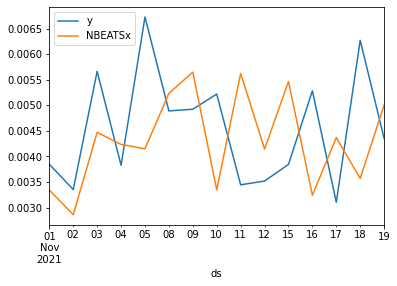

In [25]:
Y_test_df['NBEATSx'] = y_hat

pd.concat([Y_test_df]).drop(['unique_id','VIX', 'US Financial Turbulence', 'Covid'], axis=1).set_index('ds').plot()

In [36]:
y_hat = model.decompose(dataset=dataset2)

Predicting: 0it [00:00, ?it/s]

In [33]:
y_hat = model.predict(dataset=dataset2)

Predicting: 0it [00:00, ?it/s]

In [31]:
y_hat.shape

(15, 3, 1)

Text(0, 0.5, 'Exogenous')

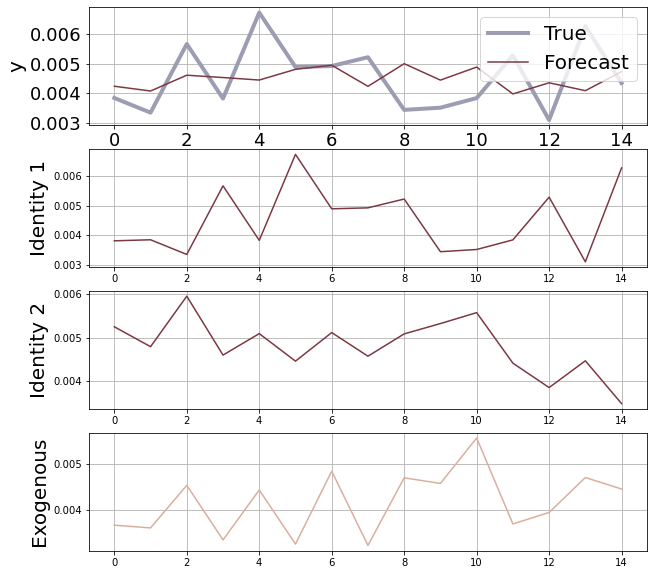

In [38]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

ax[0].plot(Y_test_df['y'].values, label='True', color="#9C9DB2", linewidth=4)
ax[0].plot(y_hat.sum(axis=1).flatten()/3, label='Forecast', color="#7B3841")
ax[0].grid()
ax[0].legend(prop={'size': 20})
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(18)
ax[0].set_ylabel('y', fontsize=20)

ax[1].plot(y_hat[:,0], label='level', color="#7B3841")
ax[1].grid()
ax[1].set_ylabel('Identity 1', fontsize=20)

ax[2].plot(y_hat[:,1], label='stack1', color="#7B3841")
ax[2].grid()
ax[2].set_ylabel('Identity 2', fontsize=20)

ax[3].plot(y_hat[:,2], label='stack2', color="#D9AE9E")
ax[3].grid()
ax[3].set_ylabel('Exogenous', fontsize=20)

In [7]:
Y_train = df[:1005]

In [8]:
Y_train.reset_index(inplace=True)

In [9]:
Y_train.rename(columns={'Date':'ds'}, inplace=True)

In [10]:
Y_train.rename(columns={'Realised':'y'}, inplace=True)

In [11]:
Y_train.tail(252)

,ds,unique_id,y,US Financial Turbulence,Covid,VIX
753,2020-10-30,Airline1,0.014551,715.890512,0,38.02
754,2020-11-02,Airline1,0.010540,615.136341,0,37.13
755,2020-11-03,Airline1,0.013271,751.131348,0,35.55
756,2020-11-04,Airline1,0.020328,833.304523,0,29.57
757,2020-11-05,Airline1,0.011578,780.247181,0,27.58
...,...,...,...,...,...,...
1000,2021-10-25,Airline1,0.002847,404.686444,0,15.24
1001,2021-10-26,Airline1,0.003484,616.042317,0,15.98
1002,2021-10-27,Airline1,0.004295,739.161544,0,16.98
1003,2021-10-28,Airline1,0.002801,679.375691,0,16.53


<AxesSubplot:>

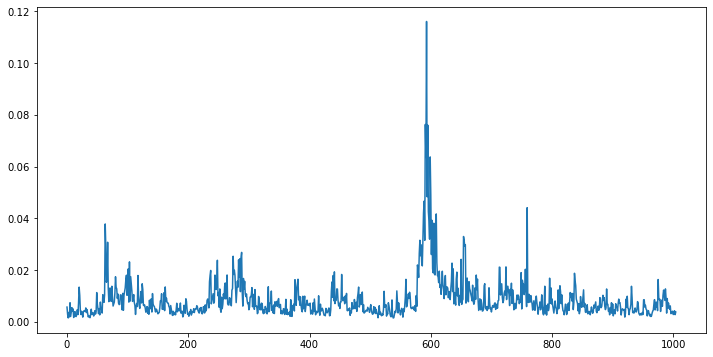

In [12]:
Y_train["y"].plot(figsize=(12,6))

# Validation

In [66]:
RMSE=[]
Accuracy=[]

In [83]:
model = NBEATSx(h=1, input_size=84,
                loss=MSE(),
                scaler_type='robust',
                stat_exog_list=['Covid'],
                learning_rate=0.0001,
                stack_types=['identity','identity'],
                n_blocks=[1, 1],
                mlp_units=[[712, 712], [712, 712]],
                windows_batch_size=30,
                num_lr_decays=4,
                val_check_steps=10,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['US Financial Turbulence','VIX'],
                max_steps=50,
                early_stop_patience_steps=0,
                random_seed=27621)
fcst = NeuralForecast(
    models=[model],
    freq=CustomBusinessDay(calendar=USFederalHolidayCalendar())
)
forecasts = fcst.cross_validation(df=Y_train,val_size=1,static_df=AirPassengersStatic,n_windows=None, test_size=99,step_size=1)

Global seed set to 27621


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [84]:
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds','US Financial Turbulence','VIX','Covid','index','cutoff'])
Y_hat=Y_hat_df["NBEATSx"].values
Y_true=Y_hat_df["y"].values
RMSE.append(rmse(y=Y_true, y_hat=Y_hat))
Accuracy.append((1-mape(y=Y_true, y_hat=Y_hat))*100)

In [85]:
RMSE

[0.0010999686346038948,
 0.0008799409066722658,
 0.0008691956763640826,
 0.0008661118545079124,
 0.0009775533526908639]

In [86]:
Accuracy

[82.55739534494553,
 88.79299347509274,
 90.58889043701075,
 90.78196968614989,
 84.96007479858618]

Random seed was chosen as the day, month and year of the experiment
Input size 21
model = NBEATSx(h=1, input_size=21,
                loss=MSE(),
                scaler_type='robust',
                stat_exog_list=['Covid'],
                learning_rate=0.0001,
                stack_types=['identity','identity'],
                n_blocks=[4, 4],
                mlp_units=[[712, 712], [712, 712]],
                windows_batch_size=30,
                num_lr_decays=4,
                val_check_steps=10,
                n_harmonics=0, n_polynomials=1,
                hist_exog_list=['US Financial Turbulence','VIX'],
                max_steps=50,
                early_stop_patience_steps=0,
                random_seed=542023)

RMSE=0.0014224637401209096
Accuracy=77.11953592852177

Input size 63
model = NBEATSx(h=1, input_size=63,
                loss=MSE(),
                scaler_type='robust',
                stat_exog_list=['Covid'],
                learning_rate=0.0001,
                stack_types=['identity','identity'],
                n_blocks=[4, 4],
                mlp_units=[[712, 712], [712, 712]],
                windows_batch_size=30,
                num_lr_decays=4,
                val_check_steps=10,
                n_harmonics=0, n_polynomials=1,
                hist_exog_list=['US Financial Turbulence','VIX'],
                max_steps=50,
                early_stop_patience_steps=0,
                random_seed=542023)

RMSE=  0.0011565650307235322
Accuracy= 81.95014894596436

Input size 84
model = NBEATSx(h=1, input_size=84,
                loss=MSE(),
                scaler_type='robust',
                stat_exog_list=['Covid'],
                learning_rate=0.0001,
                stack_types=['identity','identity'],
                n_blocks=[4, 4],
                mlp_units=[[712, 712], [712, 712]],
                windows_batch_size=30,
                num_lr_decays=4,
                val_check_steps=10,
                n_harmonics=0, n_polynomials=1,
                hist_exog_list=['US Financial Turbulence','VIX'],
                max_steps=50,
                early_stop_patience_steps=0,
                random_seed=542023)

RMSE= 0.0009513329281833965
Accuracy= 86.18378420380387

Input size 126
model = NBEATSx(h=1, input_size=126,
                loss=MSE(),
                scaler_type='robust',
                stat_exog_list=['Covid'],
                learning_rate=0.0001,
                stack_types=['identity','identity'],
                n_blocks=[4, 4],
                mlp_units=[[712, 712], [712, 712]],
                windows_batch_size=30,
                num_lr_decays=4,
                val_check_steps=10,
                n_harmonics=0, n_polynomials=1,
                hist_exog_list=['US Financial Turbulence','VIX'],
                max_steps=50,
                early_stop_patience_steps=0,
                random_seed=542023)

RMSE= 0.0010041746984801646
Accuracy= 84.98428628645881

Input size 189
model = NBEATSx(h=1, input_size=189,
                loss=MSE(),
                scaler_type='robust',
                stat_exog_list=['Covid'],
                learning_rate=0.0001,
                stack_types=['identity','identity'],
                n_blocks=[4, 4],
                mlp_units=[[712, 712], [712, 712]],
                windows_batch_size=30,
                num_lr_decays=4,
                val_check_steps=10,
                n_harmonics=0, n_polynomials=1,
                hist_exog_list=['US Financial Turbulence','VIX'],
                max_steps=50,
                early_stop_patience_steps=0,
                random_seed=542023)

RMSE= 0.0011199787053421538
Accuracy=81.17329908571774

Input size 252
model = NBEATSx(h=1, input_size=252,
                loss=MSE(),
                scaler_type='robust',
                stat_exog_list=['Covid'],
                learning_rate=0.0001,
                stack_types=['identity','identity'],
                n_blocks=[4, 4],
                mlp_units=[[712, 712], [712, 712]],
                windows_batch_size=30,
                num_lr_decays=4,
                val_check_steps=10,
                n_harmonics=0, n_polynomials=1,
                hist_exog_list=['US Financial Turbulence','VIX'],
                max_steps=50,
                early_stop_patience_steps=0,
                random_seed=542023)

RMSE= 0.001040589459814945
Accuracy= 83.88190124282649

Input size 84 was chosen
Changing random seed to 1 for other hyperparameters selection

model = NBEATSx(h=1, input_size=84,
                loss=MSE(),
                scaler_type='robust',
                stat_exog_list=['Covid'],
                learning_rate=0.0001,
                stack_types=['identity','identity'],
                n_blocks=[4, 4],
                mlp_units=[[712, 712], [712, 712]],
                windows_batch_size=30,
                num_lr_decays=4,
                val_check_steps=10,
                n_harmonics=0, n_polynomials=1,
                hist_exog_list=['US Financial Turbulence','VIX'],
                max_steps=50,
                early_stop_patience_steps=0,
                random_seed=1)

RMSE=0.0011434857978181044
Accuracy=81.72393301162977

Scaler type = standard
model = NBEATSx(h=1, input_size=84,
                loss=MSE(),
                scaler_type='standard',
                stat_exog_list=['Covid'],
                learning_rate=0.0001,
                stack_types=['identity','identity'],
                n_blocks=[4, 4],
                mlp_units=[[712, 712], [712, 712]],
                windows_batch_size=30,
                num_lr_decays=4,
                val_check_steps=10,
                n_harmonics=0, n_polynomials=1,
                hist_exog_list=['US Financial Turbulence','VIX'],
                max_steps=50,
                early_stop_patience_steps=0,
                random_seed=1)

RMSE= 0.0011631238331389385
Accuracy= 82.65341519722865

Robust was chosen as scaler type

n_blocks = [1,1]
model = NBEATSx(h=1, input_size=84,
                loss=MSE(),
                scaler_type='robust',
                stat_exog_list=['Covid'],
                learning_rate=0.0001,
                stack_types=['identity','identity'],
                n_blocks=[1, 1],
                mlp_units=[[712, 712], [712, 712]],
                windows_batch_size=30,
                num_lr_decays=4,
                val_check_steps=10,
                n_harmonics=0, n_polynomials=1,
                hist_exog_list=['US Financial Turbulence','VIX'],
                max_steps=50,
                early_stop_patience_steps=0,
                random_seed=1)

RMSE=0.0009166911728693125
Accuracy=88.25705004392843

n_blocks = [2,2]
model = NBEATSx(h=1, input_size=84,
                loss=MSE(),
                scaler_type='robust',
                stat_exog_list=['Covid'],
                learning_rate=0.0001,
                stack_types=['identity','identity'],
                n_blocks=[2, 2],
                mlp_units=[[712, 712], [712, 712]],
                windows_batch_size=30,
                num_lr_decays=4,
                val_check_steps=10,
                n_harmonics=0, n_polynomials=1,
                hist_exog_list=['US Financial Turbulence','VIX'],
                max_steps=50,
                early_stop_patience_steps=0,
                random_seed=1)

RMSE=0.00099139278621615
Accuracy=84.84376147268704

n_blocks = [3,3]
model = NBEATSx(h=1, input_size=84,
                loss=MSE(),
                scaler_type='robust',
                stat_exog_list=['Covid'],
                learning_rate=0.0001,
                stack_types=['identity','identity'],
                n_blocks=[3, 3],
                mlp_units=[[712, 712], [712, 712]],
                windows_batch_size=30,
                num_lr_decays=4,
                val_check_steps=10,
                n_harmonics=0, n_polynomials=1,
                hist_exog_list=['US Financial Turbulence','VIX'],
                max_steps=50,
                early_stop_patience_steps=0,
                random_seed=1)

RMSE=0.0010999686346038948
Accuracy=82.55739534494553

n_blocks = [1,1] was chosen
Changing random seed to 27621 for remaning hyperparameters selection

model = NBEATSx(h=1, input_size=84,
                loss=MSE(),
                scaler_type='robust',
                stat_exog_list=['Covid'],
                learning_rate=0.0001,
                stack_types=['identity','identity'],
                n_blocks=[4, 4],
                mlp_units=[[712, 712], [712, 712]],
                windows_batch_size=30,
                num_lr_decays=4,
                val_check_steps=10,
                n_harmonics=0, n_polynomials=1,
                hist_exog_list=['US Financial Turbulence','VIX'],
                max_steps=50,
                early_stop_patience_steps=0,
                random_seed=27621)

RMSE=0.0008799409066722658
Accuracy=88.79299347509274



Hyperparameters selection finalized


Model choice

model = NBEATSx(h=1, input_size=84,
                loss=MSE(),
                scaler_type='robust',
                stat_exog_list=['Covid'],
                learning_rate=0.0001,
                stack_types=['identity','identity'],
                n_blocks=[1, 1],
                mlp_units=[[712, 712], [712, 712]],
                windows_batch_size=30,
                num_lr_decays=4,
                val_check_steps=10,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['US Financial Turbulence','VIX'],
                max_steps=50,
                early_stop_patience_steps=0,
                random_seed=27621)

In [7]:
Y_train = df
Y_train.reset_index(inplace=True)
Y_train.rename(columns={'Date':'ds'}, inplace=True)
Y_train.rename(columns={'Realised':'y'}, inplace=True)

In [8]:
RMSEs=[]
Accuracy=[]

In [9]:
model = NBEATSx(h=1, input_size=84,
                loss=MSE(),
                scaler_type='robust',
                stat_exog_list=['Covid'],
                learning_rate=0.0001,
                stack_types=['identity','identity'],
                n_blocks=[1, 1],
                mlp_units=[[712, 712], [712, 712]],
                windows_batch_size=30,
                num_lr_decays=4,
                val_check_steps=10,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=50,
                early_stop_patience_steps=0,
                random_seed=random.randint(0, 1000000))
fcst = NeuralForecast(
    models=[model],
    freq=CustomBusinessDay(calendar=USFederalHolidayCalendar())
)



Global seed set to 310862


In [180]:
model = NBEATSx(h=1, input_size=84,
                loss=MSE(),
                scaler_type='robust',
                stat_exog_list=['Covid'],
                learning_rate=0.0001,
                stack_types=['identity','identity'],
                n_blocks=[1, 1],
                mlp_units=[[712, 712], [712, 712]],
                windows_batch_size=30,
                num_lr_decays=4,
                val_check_steps=10,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=50,
                early_stop_patience_steps=0,
                random_seed=random.randint(0, 1000000))
fcst = NeuralForecast(
    models=[model],
    freq=CustomBusinessDay(calendar=USFederalHolidayCalendar())
)
forecasts = fcst.cross_validation(df=Y_train,val_size=1,static_df=AirPassengersStatic,n_windows=None, test_size=252,step_size=1)

Global seed set to 69124


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [181]:
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds','US Financial Turbulence','VIX','Covid','index','cutoff'])
Y_hat=Y_hat_df["NBEATSx"].values
Y_true=Y_hat_df["y"].values
RMSEs.append(rmse(y=Y_true, y_hat=Y_hat))
Accuracy.append((1-mape(y=Y_true, y_hat=Y_hat))*100)

In [192]:
RMSEs

[0.0029056234053836724,
 0.002936415016351853,
 0.002899537560820656,
 0.0029137609890778934,
 0.002940447089840409,
 0.002967435571158036,
 0.002960777345100231,
 0.0029205792530728504,
 0.002953528558115537,
 0.002915335287104063,
 0.0029586591597438594,
 0.002939838800905166,
 0.002904184383856103,
 0.0029532817523762046,
 0.0029431218488099537]

In [193]:
Accuracy

[84.66548777904868,
 84.4830834874906,
 84.15000727664122,
 83.70809701280295,
 83.49958673753369,
 83.98681907697527,
 84.13018494585722,
 84.83110821033968,
 84.15594535157909,
 83.54010525401489,
 84.05321023261956,
 83.71872147060012,
 84.33189060886527,
 83.38963962006397,
 83.59659014634964]

Text(0, 0.5, 'DJIA Realized Volatility')

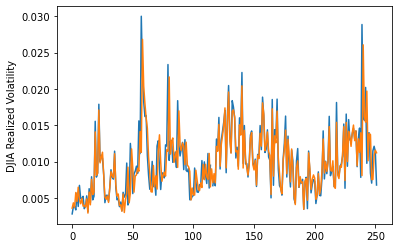

In [147]:
plt.plot(range(len(Y_hat)),Y_true)
plt.plot(range(len(Y_hat)),Y_hat)
plt.ylabel("DJIA Realized Volatility")

In [194]:
RMSE=RMSEs

In [195]:
print("mean: %s" %(round(np.mean(RMSE),5)*100)+"%")

mean: 0.293%


In [196]:
print("stdv: %s" %(round(np.std(RMSE),5)*100)+"%")

stdv: 0.002%


In [197]:
RMSE_CI_95_lower_bound=np.mean(RMSE)-2*np.std(RMSE)
RMSE_CI_95_upper_bound=np.mean(RMSE)+2*np.std(RMSE)
print("95 percent CI lower bound: %s" %(round(RMSE_CI_95_lower_bound,5)*100)+"%")
print("95 percent CI upper bound: %s" %(round(RMSE_CI_95_upper_bound,5)*100)+"%")

95 percent CI lower bound: 0.28900000000000003%
95 percent CI upper bound: 0.298%


In [198]:
RMSE_CI_99_lower_bound=np.mean(RMSE)-3*np.std(RMSE)
RMSE_CI_99_upper_bound=np.mean(RMSE)+3*np.std(RMSE)
print("99.7 percent CI lower bound: %s" %(round(RMSE_CI_99_lower_bound,5)*100)+"%")
print("99.7 percent CI upper bound: %s" %(round(RMSE_CI_99_upper_bound,5)*100)+"%")

99.7 percent CI lower bound: 0.28700000000000003%
99.7 percent CI upper bound: 0.3%


In [199]:
Accuracy

[84.66548777904868,
 84.4830834874906,
 84.15000727664122,
 83.70809701280295,
 83.49958673753369,
 83.98681907697527,
 84.13018494585722,
 84.83110821033968,
 84.15594535157909,
 83.54010525401489,
 84.05321023261956,
 83.71872147060012,
 84.33189060886527,
 83.38963962006397,
 83.59659014634964]

In [200]:
print("mean: %s" %(round(np.mean(Accuracy),2))+"%")

mean: 84.02%


In [201]:
print("stdv: %s" %(round(np.std(Accuracy),2))+"%")

stdv: 0.42%


In [202]:
Accuracy_CI_95_lower_bound=np.mean(Accuracy)-2*np.std(Accuracy)
Accuracy_CI_95_upper_bound=np.mean(Accuracy)+2*np.std(Accuracy)
print("95 percent CI lower bound: %s" %round(Accuracy_CI_95_lower_bound,2)+"%")
print("95 percent CI upper bound: %s" %round(Accuracy_CI_95_upper_bound,2)+"%")

95 percent CI lower bound: 83.17%
95 percent CI upper bound: 84.86%


In [203]:
Accuracy_CI_99_lower_bound=np.mean(Accuracy)-3*np.std(Accuracy)
Accuracy_CI_99_upper_bound=np.mean(Accuracy)+3*np.std(Accuracy)
print("99.7 percent CI lower bound: %s" %round(Accuracy_CI_99_lower_bound,2)+"%")
print("99.7 percent CI upper bound: %s" %round(Accuracy_CI_99_upper_bound,2)+"%")

99.7 percent CI lower bound: 82.74%
99.7 percent CI upper bound: 85.29%


(array([19012., 19013., 19014., 19015., 19016., 19017., 19018.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

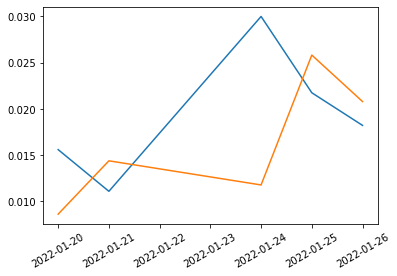

In [204]:
plt.plot(forecasts["ds"][55:60],Y_true[55:60])
plt.plot(forecasts["ds"][55:60],Y_hat[55:60])
plt.xticks(rotation=30)

(0.006, 0.028)

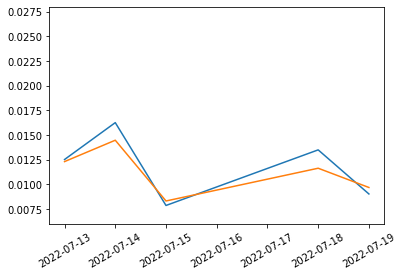

In [205]:
plt.plot(forecasts["ds"][175:180],Y_true[175:180])
plt.plot(forecasts["ds"][175:180],Y_hat[175:180])
plt.xticks(rotation=30)
ax = plt.gca()
ax.set_ylim(0.006, 0.028)